# Optimizer tweaks

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_08 import *

## Imagenette data

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [ ]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
il = ImageItemList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)

In [ ]:
bs=64

In [ ]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=8)

In [ ]:
x,y = next(iter(valid_dl))

'n01440764'

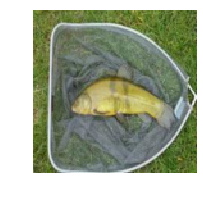

In [ ]:
show_image(x[0])
ll.train.y.processor.vocab[y[0]]

In [ ]:
nfs = [32,64,128,256,512]

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
data = DataBunch(train_dl, valid_dl, 3, 10)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
run.fit(1, learn)

train: [1.7552630159861176, tensor(0.3979, device='cuda:0')]
valid: [1.8413565673828125, tensor(0.4140, device='cuda:0')]


## Momentum

### Base optimizer

In [ ]:
optim.Optimizer??

In [ ]:
class Optimizer(optim.Optimizer):
    def __init__(self, params, lr=0.4): super().__init__(params, dict(lr=lr))
    def step(self):
        for pg in self.param_groups:
            for p in pg['params']:
                if p.grad is not None: p.data.add_(-pg['lr'], self.get_step(pg, p))
                    
    def get_step(self, pg, p): return p.grad.data

In [ ]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, opt_func=Optimizer, cbs=cbfs)

In [ ]:
%time run.fit(2, learn)

train: [1.7323643143128586, tensor(0.4159, device='cuda:0')]
valid: [1.6147132568359375, tensor(0.4820, device='cuda:0')]
train: [1.3232830858829687, tensor(0.5618, device='cuda:0')]
valid: [1.43192236328125, tensor(0.5480, device='cuda:0')]
CPU times: user 28.2 s, sys: 13.8 s, total: 42 s
Wall time: 43.5 s


### Implement momentum

In [ ]:
class MomentumStats():
    def __init__(self, mom=0.9): self.mom,self.step = mom,None
    
    def update(self, grad):
        if self.step is None: self.step = grad.clone()
        else: self.step.mul_(self.mom).add_(grad)
        return self.step

In [ ]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, stats_func, lr=0.4):
        super().__init__(params, lr=lr)
        self.stats_func = stats_func

    def get_state(self, p):
        # First time this param seen - create a stats obj for it and put it in `state`
        if p not in self.state: self.state[p] = self.stats_func()
        return self.state[p]
    
    def get_step(self, pg, p):
        # PyTorch will save anything stored in `state`; it's indexed by param
        stats = self.get_state(p)
        return stats.update(p.grad.data)

In [ ]:
opt_func = partial(StatefulOptimizer, stats_func=MomentumStats)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.05, conv_layer, opt_func=opt_func, cbs=cbfs)

In [ ]:
%time run.fit(2, learn)

train: [1.7098329407088568, tensor(0.4044, device='cuda:0')]
valid: [1.594976806640625, tensor(0.4640, device='cuda:0')]
train: [1.2779875208430278, tensor(0.5729, device='cuda:0')]
valid: [1.2885882568359375, tensor(0.5560, device='cuda:0')]
CPU times: user 28 s, sys: 13.9 s, total: 41.9 s
Wall time: 43.5 s


### Momentum experiments

In [ ]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5,0.7,0.9,0.99]

In [ ]:
def plot_mom(f):
    _,axs = plt.subplots(2,2, figsize=(12,8))
    for beta,ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg,res = 0,[]
        for i,yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

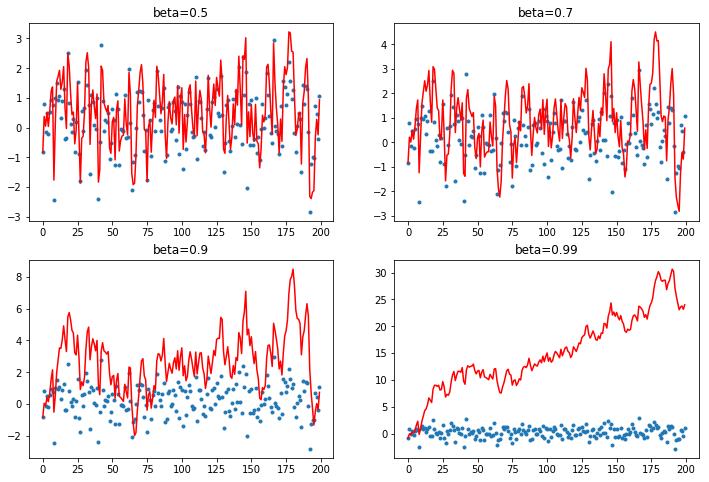

In [ ]:
def mom1(avg, beta, yi, i): 
    res = beta * avg + yi
    return res,res
plot_mom(mom1)

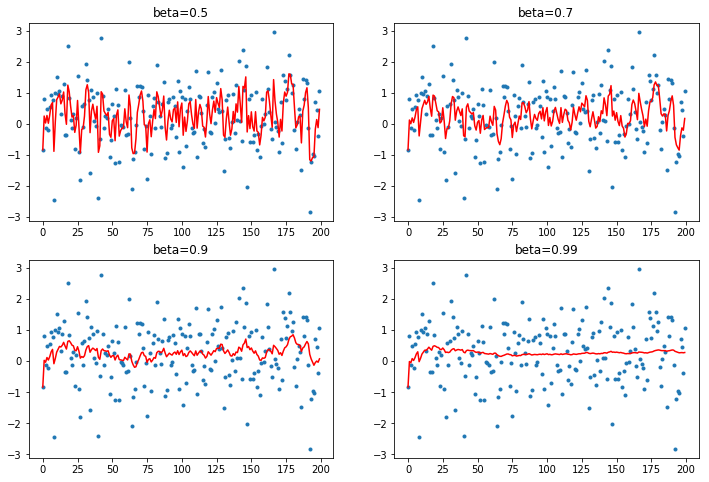

In [ ]:
def mom2(avg, beta, yi, i):
    avg = beta * avg + (1-beta) * yi
    return avg, avg/(1-beta**(i+1))
plot_mom(mom2)

In [ ]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

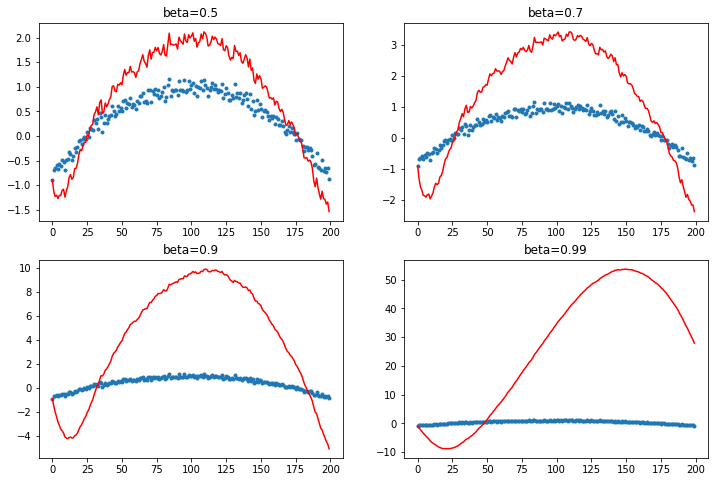

In [ ]:
plot_mom(mom1)

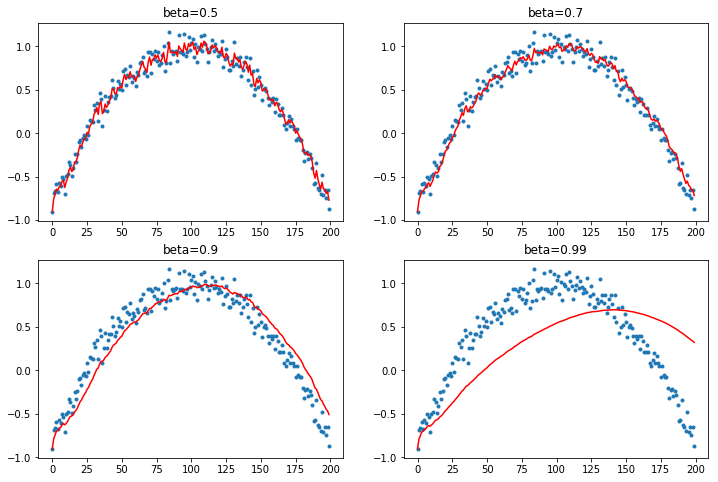

In [ ]:
plot_mom(mom2)

### Adam and friends

In [ ]:
class GradStats():
    def __init__(self, grad_mom=0, sqr_mom=0, grad_damp=None, sqr_damp=None, eps=1e-6):
        if grad_damp is None: grad_damp = 1-grad_mom
        if sqr_damp is None:  sqr_damp  = 1-sqr_mom
        self.grad_mom ,self.sqr_mom  = grad_mom ,sqr_mom
        self.grad_damp,self.sqr_damp = grad_damp,sqr_damp
        self.eps,self.grad_avg = eps,None
    
    def update(self, grad):
        if self.grad_avg is None:
            self.grad_avg,self.sqr_avg = torch.zeros_like(grad),torch.zeros_like(grad)
            self.iter = 0

        self.iter += 1
        self.grad_avg.mul_(self.grad_mom).add_(self.grad_damp,grad)
        # Inplace version of:
        # self.sqr_avg  = self.sqr_avg *self.sqr_mom  + (grad*grad)*self.sqr_damp
        self.sqr_avg.mul_(self.sqr_mom).addcmul_(self.sqr_damp,grad,grad)
        # If grad_damp==1-grad_mom:
        # debias1 = 1 - self.grad_mom**self.iter
        debias1 = self.grad_damp * (1 - self.grad_mom**self.iter) / (1-self.grad_mom)
        debias2 = self.sqr_damp  * (1 - self.sqr_mom **self.iter) / (1-self.sqr_mom )
        return self.grad_avg/debias1 / (self.sqr_avg/debias2 + self.eps).sqrt()

In [ ]:
ws = partial(GradStats, grad_mom=0.9, sqr_mom=0.99)
opt_func = partial(StatefulOptimizer, stats_func=ws)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, opt_func=opt_func, cbs=cbfs)

In [ ]:
%time run.fit(2, learn)

train: [1.797094033562122, tensor(0.4076, device='cuda:0')]
valid: [1.5447799072265624, tensor(0.5440, device='cuda:0')]
train: [1.4204100805122537, tensor(0.6009, device='cuda:0')]
valid: [1.2543931884765624, tensor(0.6700, device='cuda:0')]
CPU times: user 29 s, sys: 13.7 s, total: 42.7 s
Wall time: 44.2 s


In [ ]:
ws = partial(GradStats, grad_mom=0.9, sqr_mom=0.99, eps=1)
opt_func = partial(StatefulOptimizer, stats_func=ws)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, opt_func=opt_func, cbs=cbfs)

In [ ]:
%time run.fit(2, learn)

train: [1.7821991454358617, tensor(0.3899, device='cuda:0')]
valid: [1.552228271484375, tensor(0.4760, device='cuda:0')]
train: [1.3456747990829068, tensor(0.5580, device='cuda:0')]
valid: [1.317558349609375, tensor(0.5660, device='cuda:0')]
CPU times: user 28.8 s, sys: 13.6 s, total: 42.4 s
Wall time: 44 s


### Channel stats

- [Large Batch Training of Convolutional Networks](https://arxiv.org/abs/1708.03888) (LARS also uses weight statistics, not just gradient statistics. Can you add that to this class?)
- [Adafactor: Adaptive Learning Rates with Sublinear Memory Cost](https://arxiv.org/abs/1804.04235) (Adafactor combines stats over multiple sets of axes)
- [Adaptive Gradient Methods with Dynamic Bound of Learning Rate](https://arxiv.org/abs/1902.09843)

In [ ]:
class ChannelStats():
    def __init__(self, grad_mom=0, sqr_mom=0, grad_damp=None, sqr_damp=None, eps=1e-6):
        if grad_damp is None: grad_damp = 1-grad_mom
        if sqr_damp is None:  sqr_damp  = 1-sqr_mom
        self.grad_mom ,self.sqr_mom  = grad_mom ,sqr_mom
        self.grad_damp,self.sqr_damp = grad_damp,sqr_damp
        self.eps,self.grad_avg = eps,None
    
    def update(self, grad):
        if self.grad_avg is None:
            self.grad_avg,self.sqr_avg = torch.zeros_like(grad),torch.zeros_like(grad)
            self.iter = 0

        self.iter += 1
        self.grad_avg.mul_(self.grad_mom).add_(self.grad_damp,grad)
        sqr_avg = self.sqr_avg.mul(self.sqr_mom).addcmul(self.sqr_damp,grad,grad)
        debias1 = self.grad_damp * (1 - self.grad_mom**self.iter) / (1-self.grad_mom)
        debias2 = self.sqr_damp  * (1 - self.sqr_mom **self.iter) / (1-self.sqr_mom )
        res = self.grad_avg/debias1 / (sqr_avg/debias2 + self.eps).sqrt()
        self.sqr_avg = sqr_avg
        if grad.ndim==4: self.sqr_avg = sqr_avg.mean((2,3), keepdim=True)
        return res

In [ ]:
ws = partial(ChannelStats, grad_mom=0.9, sqr_mom=0.99)
opt_func = partial(StatefulOptimizer, stats_func=ws)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, opt_func=opt_func, cbs=cbfs)

In [ ]:
%time run.fit(2, learn)

train: [1.9362347252113385, tensor(0.3893, device='cuda:0')]
valid: [1.76273828125, tensor(0.4380, device='cuda:0')]
train: [1.5852090543566775, tensor(0.5688, device='cuda:0')]
valid: [1.38887939453125, tensor(0.6120, device='cuda:0')]
CPU times: user 28.8 s, sys: 13.7 s, total: 42.6 s
Wall time: 44.1 s


In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.0003, 0.003), sched_cos(0.003, 0.0001)]) 

In [ ]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, 
                          opt_func=opt_func, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [ ]:
%time run.fit(8, learn)

train: [2.0465602339266327, tensor(0.2978, device='cuda:0')]
valid: [1.87085693359375, tensor(0.3860, device='cuda:0')]
train: [1.7571355560241197, tensor(0.4774, device='cuda:0')]
valid: [1.6373489990234376, tensor(0.5320, device='cuda:0')]
train: [1.4089630775457578, tensor(0.6075, device='cuda:0')]
valid: [1.267303466796875, tensor(0.6380, device='cuda:0')]
train: [1.1028064924819683, tensor(0.6849, device='cuda:0')]
valid: [0.9245093383789063, tensor(0.7200, device='cuda:0')]
train: [0.8426244613531487, tensor(0.7493, device='cuda:0')]
valid: [0.912294189453125, tensor(0.7240, device='cuda:0')]
train: [0.5694787031516597, tensor(0.8471, device='cuda:0')]
valid: [0.791373046875, tensor(0.7620, device='cuda:0')]
train: [0.2749703183772491, tensor(0.9553, device='cuda:0')]
valid: [0.7418658447265625, tensor(0.7680, device='cuda:0')]
train: [0.14857977335630915, tensor(0.9906, device='cuda:0')]
valid: [0.7429068603515625, tensor(0.7800, device='cuda:0')]
CPU times: user 1min 57s, sys: 

## Export

In [ ]:
!./notebook2script.py 09_optimizers.ipynb

Converted 09_optimizers.ipynb to nb_09.py
